In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.special import inv_boxcox

# DATA CLEANING AND PREPARATION

In [3]:
sales_df = pd.read_csv("sales_data_set.csv")
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [4]:
features_df = pd.read_csv("Features_data_set.csv")
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
stores_df = pd.read_csv("stores_data_set.csv")
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
df_merge_one = pd.merge(sales_df, stores_df, on="Store", how="left")
df_merge_one.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,05/02/2010,24924.50,False,A,151315
1,1,1,12/02/2010,46039.49,True,A,151315
2,1,1,19/02/2010,41595.55,False,A,151315
3,1,1,26/02/2010,19403.54,False,A,151315
4,1,1,05/03/2010,21827.90,False,A,151315


In [7]:
df_merge_one.shape

(421570, 7)

In [8]:
features_df.shape

(8190, 12)

In [9]:
df = pd.merge(df_merge_one, features_df, on=["Store","Date"], how="left")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,05/02/2010,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,12/02/2010,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,19/02/2010,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,26/02/2010,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,05/03/2010,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
df.shape

(421570, 17)

In [11]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'],
      dtype='object')

In [12]:
columns_to_zero = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for column in columns_to_zero:
    df[column] = df[column].fillna(0)

df["Markdown"] = df[columns_to_zero].sum(axis=1)

In [13]:
columns_to_drop = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday_y']
df = df.drop(columns=columns_to_drop )

In [14]:
df.rename(columns={"IsHoliday_x":"IsHoliday"}, inplace=True)

In [15]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Markdown
0,1,1,05/02/2010,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,0.0
1,1,1,12/02/2010,46039.49,True,A,151315,38.51,2.548,211.242170,8.106,0.0
2,1,1,19/02/2010,41595.55,False,A,151315,39.93,2.514,211.289143,8.106,0.0
3,1,1,26/02/2010,19403.54,False,A,151315,46.63,2.561,211.319643,8.106,0.0
4,1,1,05/03/2010,21827.90,False,A,151315,46.50,2.625,211.350143,8.106,0.0


## Checking null values

In [16]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Markdown        0
dtype: int64

## Checking data types

In [17]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Markdown        float64
dtype: object

In [18]:
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

In [19]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Markdown               float64
dtype: object

In [20]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

In [21]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Markdown,Year,Month,Day
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,0.0,2010,2,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,211.242170,8.106,0.0,2010,2,12
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,211.289143,8.106,0.0,2010,2,19
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,211.319643,8.106,0.0,2010,2,26
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,211.350143,8.106,0.0,2010,3,5


In [20]:
df[(df["Month"]==2) & (df["Year"]==2012) & (df["Store"]==1) & (df["Dept"]==1)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Markdown,Year,Month,Day
104,1,1,2012-02-03,23510.49,False,A,151315,56.55,3.360,220.172015,7.348,76351.07,2012,2,3
105,1,1,2012-02-10,36988.49,True,A,151315,48.02,3.409,220.265178,7.348,36311.85,2012,2,10
106,1,1,2012-02-17,54060.10,False,A,151315,45.32,3.510,220.425759,7.348,32757.37,2012,2,17
107,1,1,2012-02-24,20124.22,False,A,151315,57.25,3.555,220.636902,7.348,26272.33,2012,2,24


In [22]:
df.to_csv("df.csv", index=False)

# EXPLORATORY DATA ANALYSIS

In [4]:
df = pd.read_csv("df.csv")

In [51]:
df[df["Weekly_Sales"]>0]["Weekly_Sales"].min()

0.01

In [27]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Markdown        float64
Year              int64
Month             int64
Day               int64
dtype: object

In [43]:
# 2010 has no data for January and 2012 has no data for November and December months.
# Data is available from Feb 2010 to Oct 2012.

In [53]:
df.shape

(421570, 15)

## 1. Impact of Markdown on Sales during Holiday and Non-Holiday weeks.

Holiday weeks with markdowns (11,991 weeks, 40%):
Average Weekly Sales: $17594.49
Holiday weeks without markdowns (17,670 weeks, 59%):
Average Weekly Sales: $16656.71


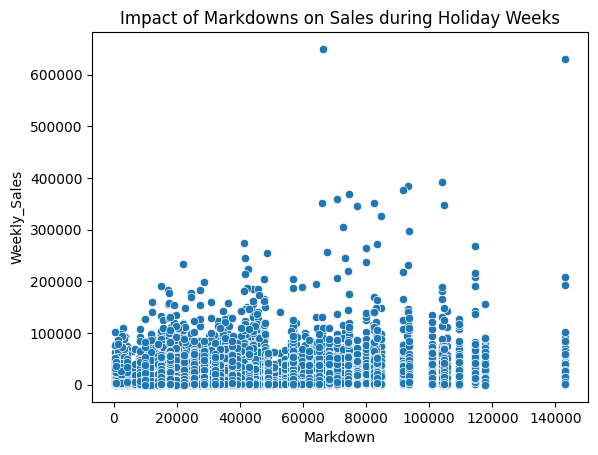

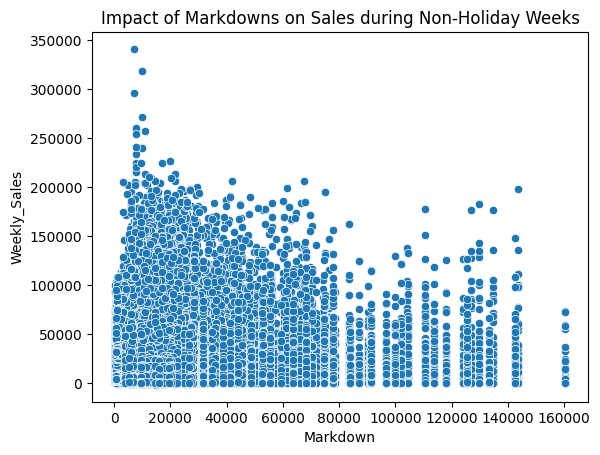

In [52]:
# Filter the data for holiday and non-holiday weeks
df_holiday = df[df["IsHoliday"] == True]  # Holiday weeks
df_non_holiday = df[df["IsHoliday"] == False]  # Non-Holiday weeks

# Separate holiday weeks with and without markdowns
markdown_holiday = df_holiday[df_holiday["Markdown"] != 0]
no_markdown_holiday = df_holiday[df_holiday["Markdown"] == 0]

# Separate non-holiday weeks with markdowns
markdown_non_holiday = df_non_holiday[df_non_holiday["Markdown"] != 0]

# Calculate average weekly sales for holiday weeks with and without markdowns
avg_sales_markdown_holiday = markdown_holiday["Weekly_Sales"].mean()
avg_sales_no_markdown_holiday = no_markdown_holiday["Weekly_Sales"].mean()

print(f"Holiday weeks with markdowns (11,991 weeks, 40%):")
print(f"Average Weekly Sales: ${avg_sales_markdown_holiday:.2f}")

print(f"Holiday weeks without markdowns (17,670 weeks, 59%):")
print(f"Average Weekly Sales: ${avg_sales_no_markdown_holiday:.2f}")

# Scatter plot to visualize markdown impact during holiday weeks
sns.scatterplot(data=markdown_holiday, x='Markdown', y='Weekly_Sales')
plt.title('Impact of Markdowns on Sales during Holiday Weeks')
plt.show()

# Scatter plot to visualize markdown impact during non-holiday weeks
sns.scatterplot(data=markdown_non_holiday, x='Markdown', y='Weekly_Sales')
plt.title('Impact of Markdowns on Sales during Non-Holiday Weeks')
plt.show()

## 2.Monthly Sale Trends

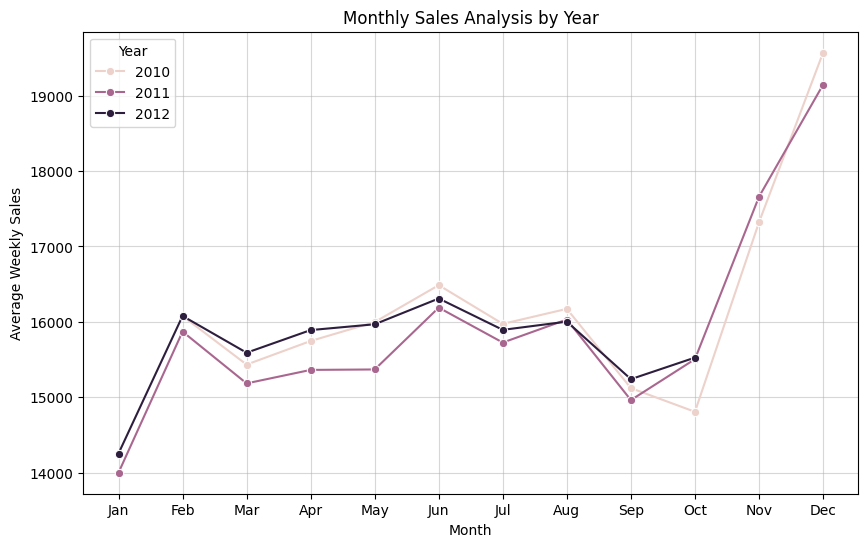

In [33]:
df_month = df[["Year", "Month", "Weekly_Sales"]]
df_month_sale_analysis = df_month.groupby(["Year", "Month"])["Weekly_Sales"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_month_sale_analysis,
    x="Month",
    y="Weekly_Sales",
    hue="Year",
    marker="o"
)

plt.title("Monthly Sales Analysis by Year")
plt.xticks(range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(alpha=0.5)
plt.show()


In [35]:
# Impact of Markdown in Festive occassions

In [25]:
df_festive = df[(df["Month"]>10) | (df["Month"]==1)]
df_festive_with_markdown = df_festive[df_festive["Markdown"]!=0]
df_festive_without_markdown = df_festive[df_festive["Markdown"]==0]
print("Average Sale where Markdown is offered: $17149")
print("Average Sale where Markdown is not offered: $16905")

Average Sale where Markdown is offered: $17149
Average Sale where Markdown is not offered: $16905


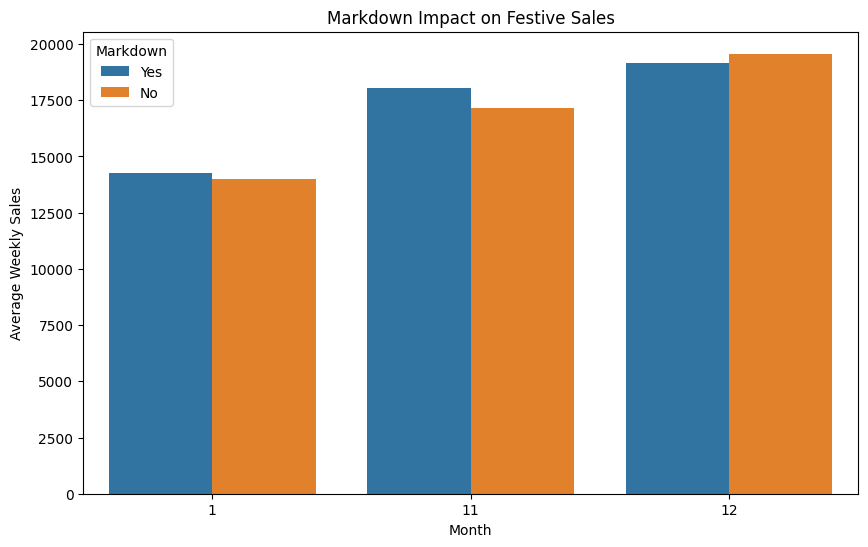

In [32]:
df1 = df_festive_with_markdown.groupby("Month")["Weekly_Sales"].mean().reset_index()
df1["Markdown"] = ["Yes","Yes","Yes"]
df2 = df_festive_without_markdown.groupby("Month")["Weekly_Sales"].mean().reset_index()
df2["Markdown"] = ["No","No","No"]
df3 = pd.concat([df1,df2], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df3, 
    x="Month", 
    y="Weekly_Sales", 
    hue="Markdown"
)

plt.title("Markdown Impact on Festive Sales")
plt.show()

## 3.Store Type Analysis

In [35]:
df_Type = df.groupby("Type")["Weekly_Sales"].mean().reset_index()

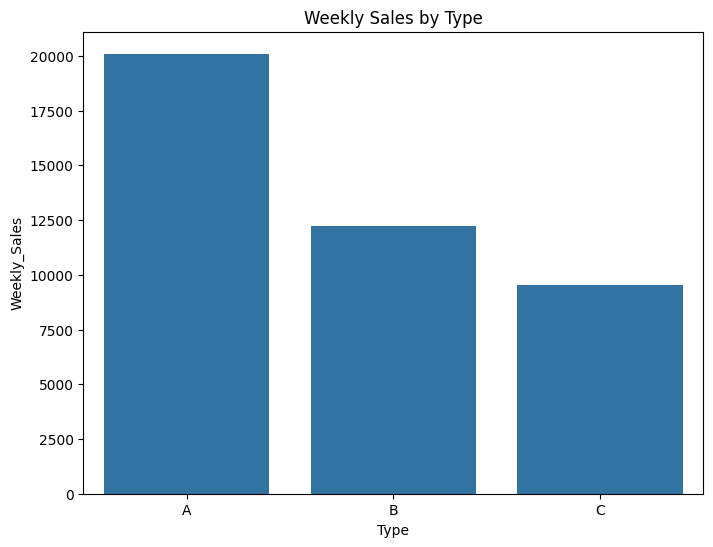

In [38]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_Type, x="Type", y="Weekly_Sales")
plt.title("Weekly Sales by Type")
plt.show()

In [ ]:
# Analyzing why sale is less in Type C

In [66]:
df["Store"].nunique()
df_TypeA = df[df["Type"]=="A"]
df_TypeB = df[df["Type"]=="B"]
df_TypeC = df[df["Type"]=="C"]
print(f"Number of stores in Type A: {df_TypeA["Store"].nunique()}\nNumber of stores in Type B: {df_TypeB["Store"].nunique()}\nNumber of stores in Type C: {df_TypeC["Store"].nunique()}")

Number of stores in Type A: 22
Number of stores in Type B: 17
Number of stores in Type C: 6


In [81]:
df4 = df[["Type","Size","Temperature","Fuel_Price","CPI","Unemployment"]]
df5 = df4.groupby("Type")[["Size","Temperature","Fuel_Price","CPI","Unemployment"]].mean().reset_index()
df5

,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,A,182231.285486,60.531945,3.343999,174.408895,7.791595
1,B,101818.735827,57.562951,3.382523,167.176656,7.928836
2,C,40535.725286,67.554266,3.364654,170.429314,8.934350


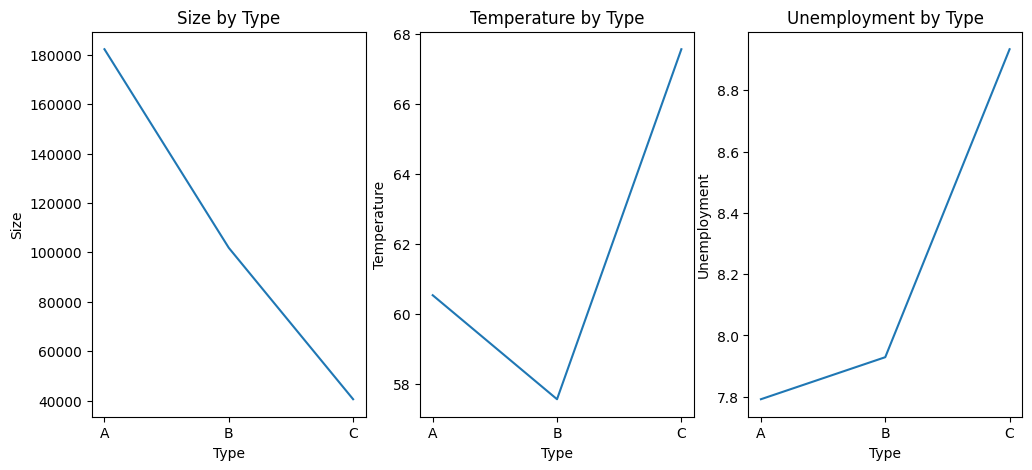

In [94]:
y_vars = ["Size", "Temperature", "Unemployment"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, y_var in enumerate(y_vars):
    sns.lineplot(df5, x="Type", y=y_var, ax=axes[i])  
    axes[i].set_title(f'{y_var} by Type') 

plt.show()

## 4.Store size and Department Sale Analysis

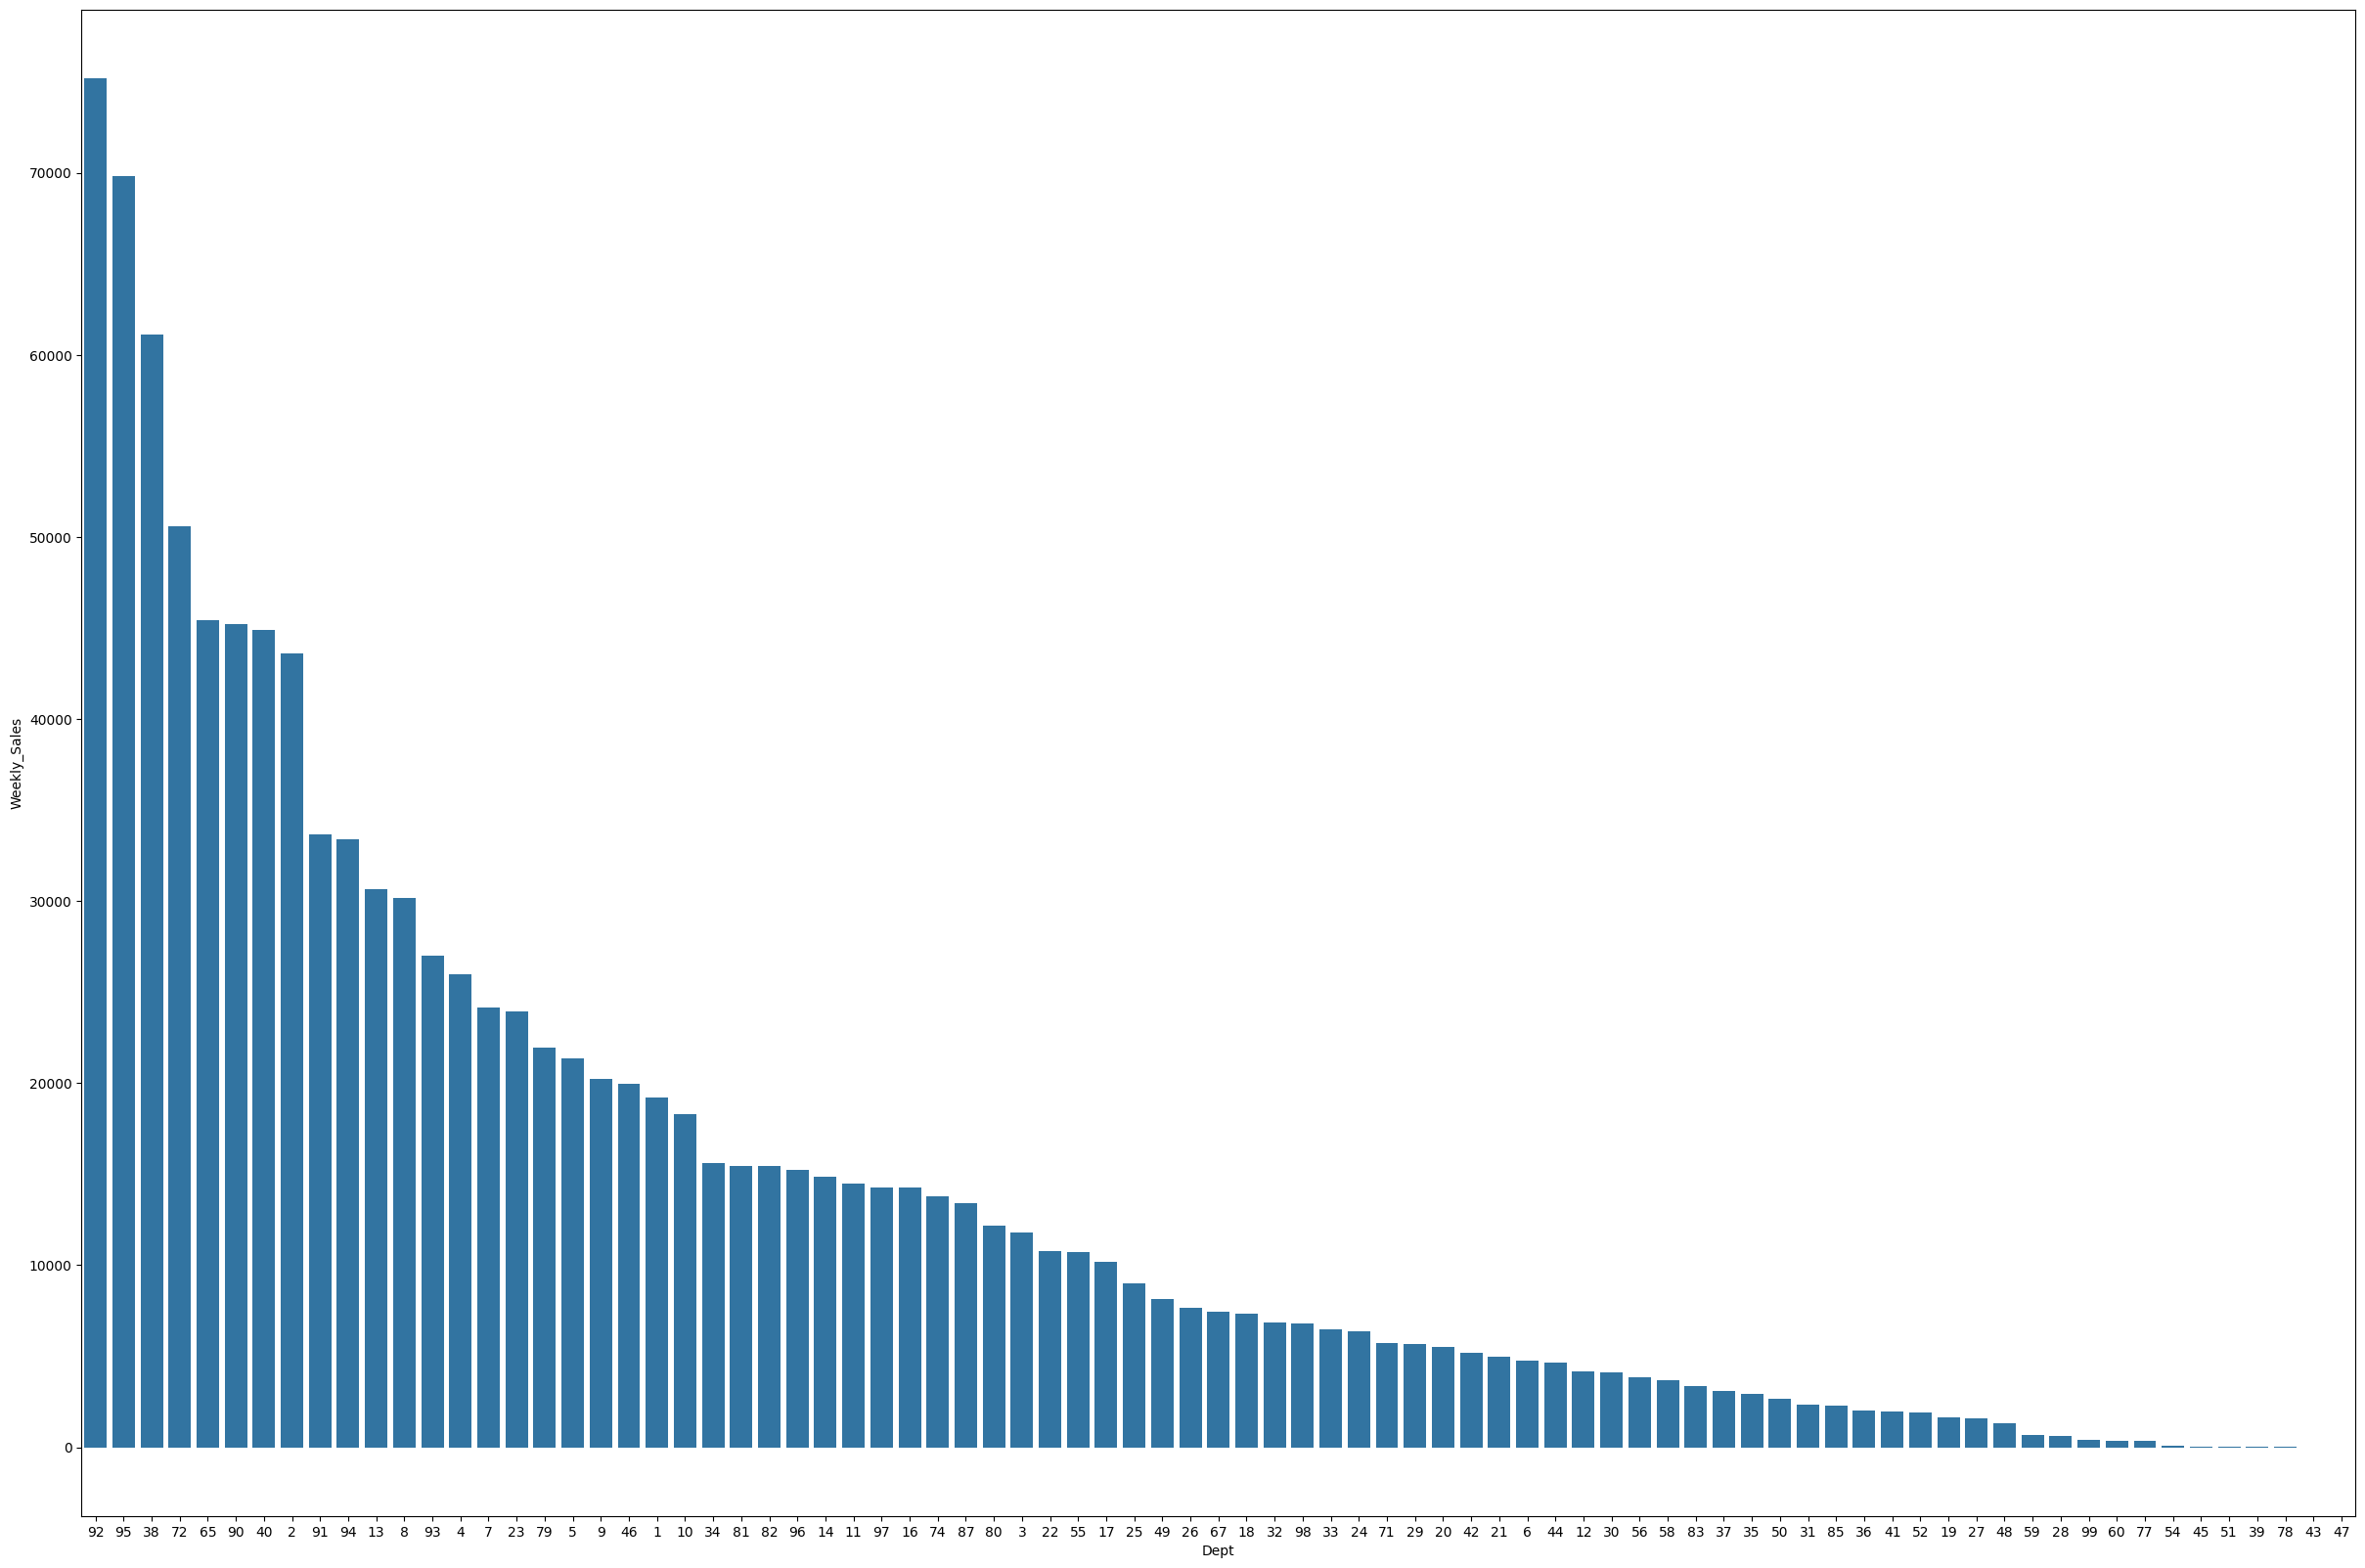

In [19]:
# Department Sale Analysis
df_dept = df.groupby("Dept")["Weekly_Sales"].mean().reset_index()
df_dept_sorted = df_dept.sort_values(by="Weekly_Sales", ascending=False)
plt.figure(figsize=(30,20))
sns.barplot(df_dept_sorted, x="Dept", y="Weekly_Sales",order=df_dept_sorted["Dept"])
plt.show()

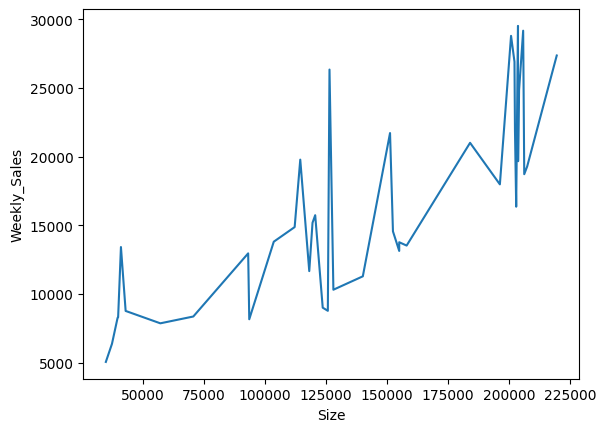

In [29]:
# Analysis based on Store Size
df_size = df.groupby("Size")["Weekly_Sales"].mean().reset_index()
sns.lineplot(df_size,x="Size",y="Weekly_Sales")
plt.show()

## INSIGHTS:
### Impact of Markdown on Sales (Holiday vs. Non-Holiday Weeks):
    - Holiday Weeks: Offering markdowns results in slightly higher sales, with an average difference of $938 compared to weeks without markdowns.
    - Non-Holiday Weeks: Markdown impacts vary widely, but sales generally don't reach the peak levels seen during holidays.
### Monthly Sales Trends:
    - Sales are highest in November and December due to the festive season (e.g., Christmas, New Year).
    - Markdown doesn't significantly drive sales during the festive months.
### Store Type Analysis:
    - Store Size: Type C stores are much smaller compared to Type A and B.
    - Temperature: Type C stores are in hotter areas, with average temperatures around 67.55°F, while Type A and B are cooler.
    - Unemployment: Type C regions have higher unemployment rates, leading to lower spending.
    - Store Count: Only 6 stores in Type C regions, compared to 22 in Type A and 17 in Type B.
### Store Size and Department Sale Analysis:
    - Higher the store size, higher the sales.
    - 92, 95, 38 are the top 3 departments with the highest weekly sale.
    
## RECOMMENDATIONS TO IMPROVE SALES:
### Optimize Markdown Strategies:
    - Holiday Weeks: More discounts can be given on high-demand items, especially those that tend to sell well during holidays.
    - Non-Holiday Weeks: Offering smaller, regular markdowns may encourage more frequent customer visits and maintain consistent sales.
### Improve Inventory Management:
    - Inventory should be stocked up in prior to meet the high sale in festive seasons.
    - Regular monitoring should be done for the items in department with higher sale and more inventory should be allocated for these departments.
    - Discounts can be provided for low sale departments to clear up the stocks.
### Store Specific Strategies:
    - New stores can be opened and size can be expanded for stores in Type C zones.
    - Air-conditioning can be provided for Type C stores and markdown can be given for products that make the environment cooler.


## FEATURE CORRELATION:

In [21]:
df["IsHoliday"] = df["IsHoliday"].map({False:0, True:1})
df["Type"] = df["Type"].map({"A":1, "B":2, "C":3})

In [43]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday         int64
Type              int64
Size              int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Markdown        float64
Year              int64
Month             int64
Day               int64
dtype: object

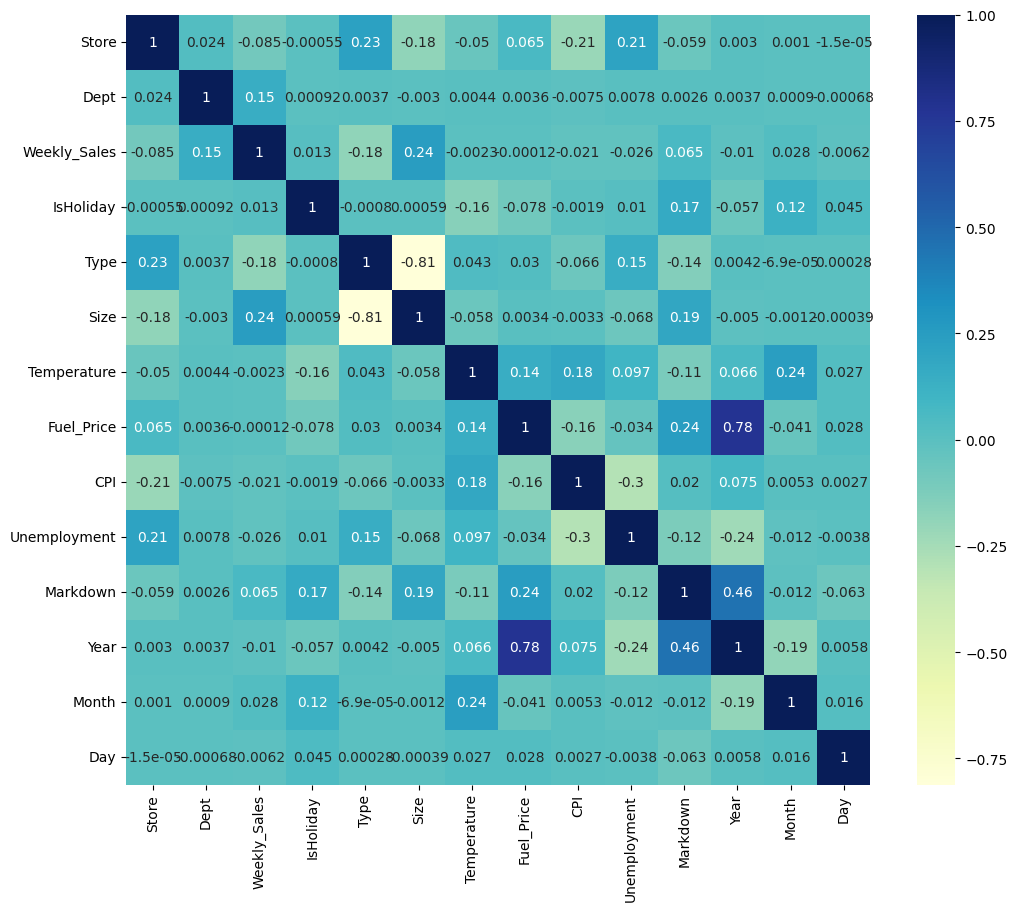

In [53]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr,annot=True,cmap="YlGnBu")
plt.show()

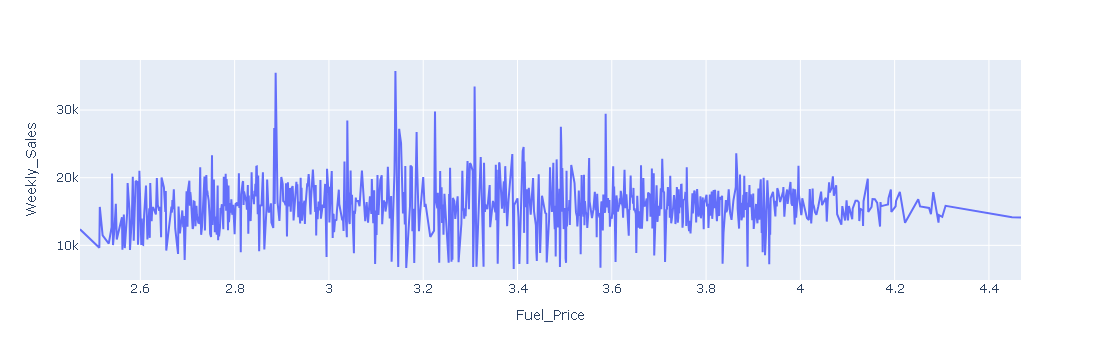

In [57]:
df6 = df.groupby("Fuel_Price")["Weekly_Sales"].mean().reset_index()
fig = px.line(df6,x="Fuel_Price",y="Weekly_Sales")
fig.show()

In [10]:
# Removing Fuel price due to high correlation(0.78).

df = df.drop(columns=['Fuel_Price'])

## SKEWNESS

In [11]:
df1 = df.copy()

In [46]:
columns = ['Weekly_Sales', 'Temperature', 'CPI', 'Unemployment', 'Markdown']
for i in columns:
    print(f'{i}:',df1[i].skew())

Weekly_Sales: 3.2620081854656657
Temperature: -0.3214041519699762
CPI: 0.08521928473260011
Unemployment: 1.1837425684974319
Markdown: 3.890905649722947


In [47]:
columns_to_transform = ['Weekly_Sales', 'Unemployment', 'Markdown']
for column in columns_to_transform:
    greater_than_zero = (df[column]>0).sum()
    equal_to_zero = (df[column] == 0).sum()
    less_than_zero = (df[column]<0).sum()
    print(f'{column}---{greater_than_zero}--{equal_to_zero}--{less_than_zero}')

Weekly_Sales---420212--73--1285
Unemployment---421570--0--0
Markdown---151432--270138--0


In [12]:
# Weekly Sales can't be negative. 0.3% of the data has negative values so removing it.
df1 = df1[df1['Weekly_Sales']>=0]

In [13]:
columns_to_transform = ['Weekly_Sales', 'Unemployment', 'Markdown']
for column in columns_to_transform:
    if (df1[column]==0).any():
        df1[column] = df1[column]+1
    df1[column], fitted_lambda = stats.boxcox(df1[column])
    print(f'{column} transformed with lambda {fitted_lambda}: skewness = {df1[column].skew()}')

Weekly_Sales transformed with lambda 0.21190295673149415: skewness = -0.075761882070792
Unemployment transformed with lambda -0.06995164335275873: skewness = -0.007087351320171858
Markdown transformed with lambda -0.19278533614859414: skewness = 0.5971198513423402


In [50]:
columns = ['Weekly_Sales', 'Unemployment', 'Markdown']
for column in columns:
    print(column,":",df[column].skew(),"After Log Transformation:",df1[column].skew())

Weekly_Sales : 3.2620081854656657 After Log Transformation: -0.075761882070792
Unemployment : 1.1837425684974319 After Log Transformation: -0.007087351320171858
Markdown : 3.890905649722947 After Log Transformation: 0.5971198513423402


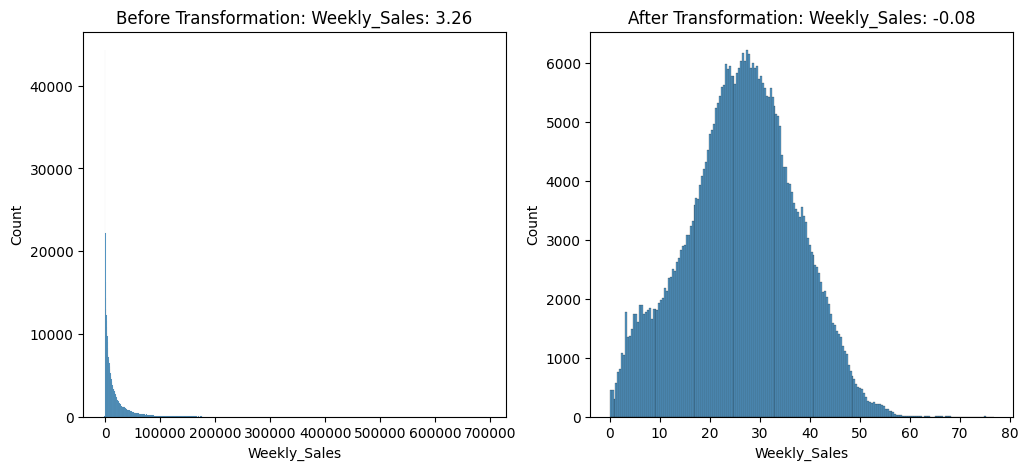

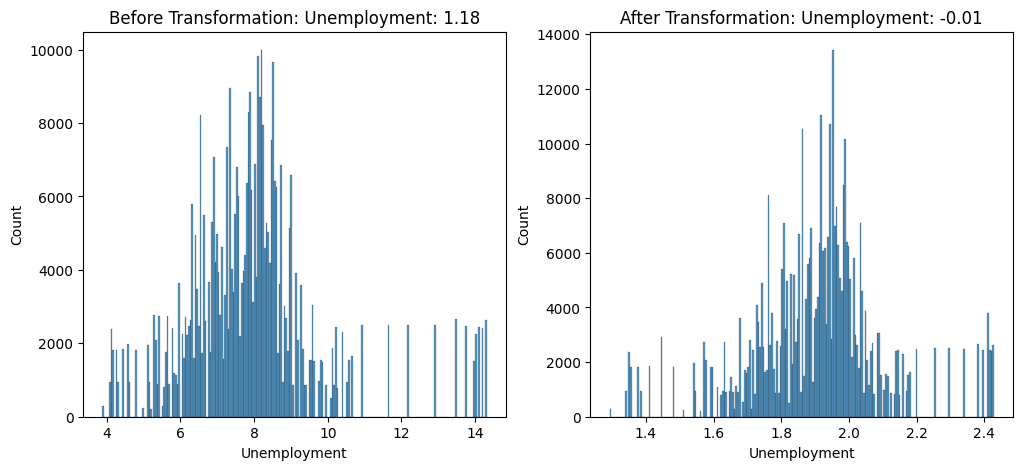

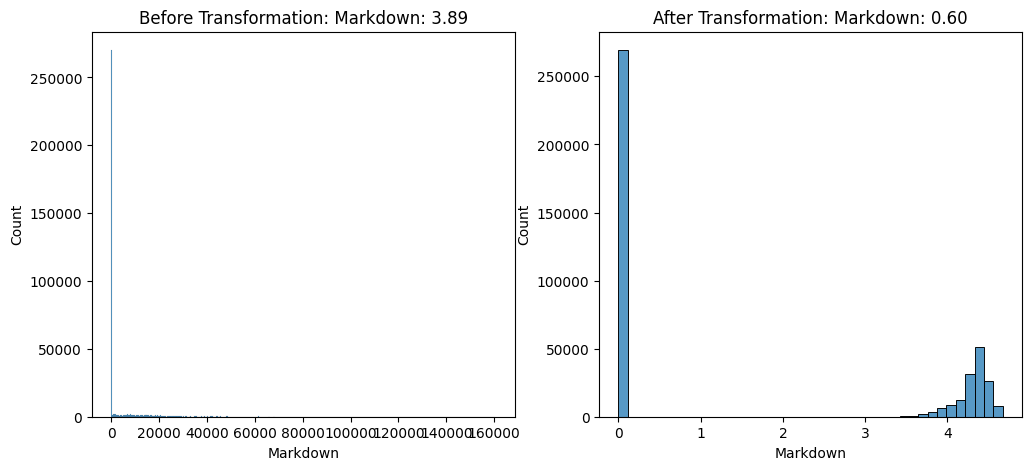

In [51]:
columns = ['Weekly_Sales', 'Unemployment', 'Markdown']
for column in columns:
    fig,axes = plt.subplots(1,2,figsize=(12,5))
    sns.histplot(df[column],ax=axes[0])
    axes[0].set_title(f'Before Transformation: {column}: {df[column].skew():.2f}')
    sns.histplot(df1[column],ax=axes[1])
    axes[1].set_title(f'After Transformation: {column}: {df1[column].skew():.2f}')
    plt.show()

In [14]:
df2 = df1.copy()

## OUTLIERS

In [56]:
columns = ['Weekly_Sales','Size', 'Temperature', 'CPI', 'Unemployment', 'Markdown']
for column in columns:
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3-Q1
    outliers = df2[(df2[column]<(Q1-(1.5*IQR))) | (df2[column]>(Q3+(1.5*IQR)))]
    print(column,outliers.shape)

Weekly_Sales (494, 15)
Size (0, 15)
Temperature (67, 15)
CPI (0, 15)
Unemployment (36381, 15)
Markdown (0, 15)


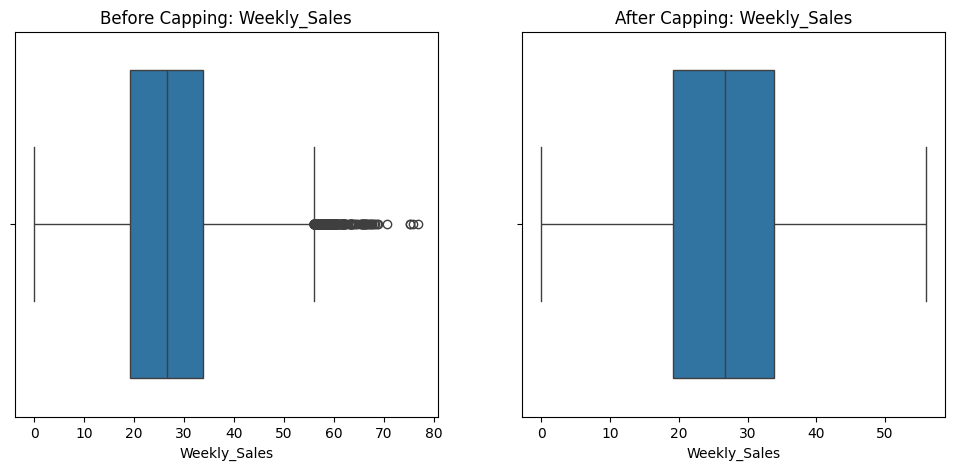

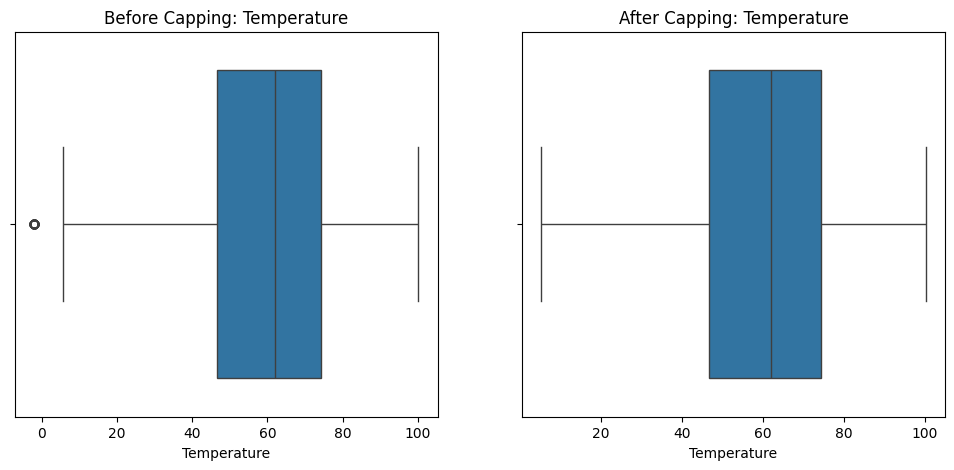

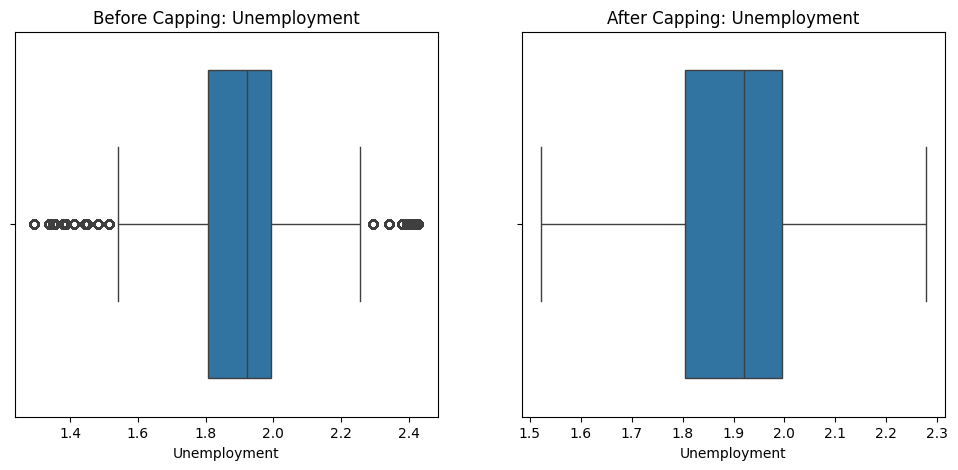

In [15]:
columns = ['Weekly_Sales', 'Temperature', 'Unemployment']
for column in columns:
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-(1.5*IQR)
    upper_bound = Q3+(1.5*IQR)
    df2[column] = df2[column].apply(lambda i:lower_bound if i<lower_bound else (upper_bound if i>upper_bound else i))
    fig,axes = plt.subplots(1,2,figsize=(12,5))
    sns.boxplot(x=df1[column], ax=axes[0])
    axes[0].set_title(f"Before Capping: {column}")
    sns.boxplot(x=df2[column],ax=axes[1])
    axes[1].set_title(f'After Capping: {column}')
    plt.show()

In [16]:
df3 = df2.copy()

## FEATURE ENGINEERING

In [ ]:
# Create lag features, holiday-specific features, and interaction features between markdowns and holidays.
# 1. Holiday Specific feature is already done.
# 2. Fuel Price has been removed since it is highly correlated.

In [ ]:
# Without Lag Features: The model only knows about the current week's features (e.g., markdown, holiday, etc.). It has no information on how sales have been behaving in the past, so it cannot detect trends or seasonality. It predicts based on the present data alone.

# With Lag Features: The model is "aware" of the sales (or other feature values) from past weeks and can detect trends (e.g., if sales have been going up or down) and adjust its predictions accordingly. This is especially useful for time series data where past behavior strongly influences future outcomes.

In [17]:
df4 = df3.copy()

In [18]:
# Creating Lag_Faeture for Weekly Sales.
df4['Weekly_Sales_Lag1'] = df4['Weekly_Sales'].shift(1)
df4['Weekly_Sales_Lag2'] = df4['Weekly_Sales'].shift(2)

In [19]:
# Creating interaction features between markdowns and holidays
df4['Markdown_Holiday_Only'] = df4['Markdown'] * (df4['IsHoliday'] ==1)
df4['Markdown_NonHoliday_Only'] = df4['Markdown'] * (df4['IsHoliday'] == 0)  

In [79]:
df4

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,CPI,Unemployment,Markdown,Year,Month,Day,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Markdown_Holiday_Only,Markdown_NonHoliday_Only
0,1,1,2010-02-05,35.283970,0,1,151315,42.31,211.096358,1.946930,0.000000,2010,2,5,NaN,NaN,0.0,0.000000
1,1,1,2010-02-12,40.805690,1,1,151315,38.51,211.242170,1.946930,0.000000,2010,2,12,35.283970,NaN,0.0,0.000000
2,1,1,2010-02-19,39.842356,0,1,151315,39.93,211.289143,1.946930,0.000000,2010,2,19,40.805690,35.283970,0.0,0.000000
3,1,1,2010-02-26,33.228030,0,1,151315,46.63,211.319643,1.946930,0.000000,2010,2,26,39.842356,40.805690,0.0,0.000000
4,1,1,2010-03-05,34.181213,0,1,151315,46.50,211.350143,1.946930,0.000000,2010,3,5,33.228030,39.842356,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,12.903529,0,2,118221,64.88,192.013558,2.006303,4.299277,2012,9,28,12.594422,13.566060,0.0,4.299277
421566,45,98,2012-10-05,13.704531,0,2,118221,64.89,192.170412,2.004618,4.302688,2012,10,5,12.903529,12.594422,0.0,4.302688
421567,45,98,2012-10-12,15.852902,0,2,118221,54.47,192.327265,2.004618,4.234035,2012,10,12,13.704531,12.903529,0.0,4.234035
421568,45,98,2012-10-19,14.458132,0,2,118221,56.47,192.330854,2.004618,4.137971,2012,10,19,15.852902,13.704531,0.0,4.137971


## MODELLING

In [61]:
df4.dtypes

Store                         int64
Dept                          int64
Date                         object
Weekly_Sales                float64
IsHoliday                     int64
Type                          int64
Size                          int64
Temperature                 float64
CPI                         float64
Unemployment                float64
Markdown                    float64
Year                          int64
Month                         int64
Day                           int64
Weekly_Sales_Lag1           float64
Weekly_Sales_Lag2           float64
Markdown_Holiday_Only       float64
Markdown_NonHoliday_Only    float64
dtype: object

In [64]:
df4.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'CPI', 'Unemployment', 'Markdown', 'Year', 'Month',
       'Day', 'Weekly_Sales_Lag1', 'Weekly_Sales_Lag2',
       'Markdown_Holiday_Only', 'Markdown_NonHoliday_Only'],
      dtype='object')

In [20]:
df4 = df4.drop(columns="Date")
df4.dropna(inplace=True)

In [18]:
df4.isna().sum()

Store                       0
Dept                        0
Weekly_Sales                0
IsHoliday                   0
Type                        0
Size                        0
Temperature                 0
CPI                         0
Unemployment                0
Markdown                    0
Year                        0
Month                       0
Day                         0
Weekly_Sales_Lag1           0
Weekly_Sales_Lag2           0
Markdown_Holiday_Only       0
Markdown_NonHoliday_Only    0
dtype: int64

In [34]:
df4["Weekly_Sales_Lag1"].max()

55.88868498227317

In [35]:
df[(df["Store"]==3) & (df["Dept"]==1) & (df["Day"]==27)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,CPI,Unemployment,Markdown,Year,Month,Day
20511,3,1,2010-08-27,3917.19,0,2,37392,86.15,214.889794,7.346,0.00,2010,8,27
20550,3,1,2011-05-27,5194.21,0,2,37392,84.41,218.886077,7.574,0.00,2011,5,27
20585,3,1,2012-01-27,8381.18,0,2,37392,58.06,223.564584,6.833,1457.26,2012,1,27
20598,3,1,2012-04-27,7145.20,0,2,37392,73.39,225.124353,6.664,1570.12,2012,4,27
20611,3,1,2012-07-27,7834.40,0,2,37392,84.94,225.453758,6.334,6380.41,2012,7,27


In [15]:
# splitting dependent and Independent variables
X = df4.drop(columns=["Weekly_Sales"])
y = df4["Weekly_Sales"]

In [16]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape[1]

16

In [119]:
print(X_scaled)

[[0.         0.         0.         ... 0.63762023 0.         0.        ]
 [0.         0.         0.         ... 0.73740379 0.         0.        ]
 [0.         0.         0.         ... 0.71999529 0.         0.        ]
 ...
 [1.         0.98979592 0.         ... 0.23318099 0.         0.90612761]
 [1.         0.98979592 0.         ... 0.24765598 0.         0.88556904]
 [1.         0.98979592 0.         ... 0.28647942 0.         0.89719422]]


### Architecture 1

In [18]:
model_one = Sequential()
model_one.add(Dense(64, input_dim=X_train.shape[1], activation=LeakyReLU(alpha=0.001)))
model_one.add(Dense(32, activation=LeakyReLU(alpha=0.001)))
model_one.add(Dense(1))

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model_one.compile(
    optimizer="adam",
    loss="mean_squared_error",  
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),  
        tf.keras.metrics.MeanSquaredError(),  
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.R2Score()
    ]
)

In [20]:
result_one = model_one.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

Epoch 1/30
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 45.8292 - mean_absolute_error: 3.1211 - mean_squared_error: 45.8292 - r2_score: 0.6191 - root_mean_squared_error: 5.7736 - val_loss: 4.6500 - val_mean_absolute_error: 1.2283 - val_mean_squared_error: 4.6500 - val_r2_score: 0.9609 - val_root_mean_squared_error: 2.1564
Epoch 2/30
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 4.6392 - mean_absolute_error: 1.2320 - mean_squared_error: 4.6392 - r2_score: 0.9611 - root_mean_squared_error: 2.1537 - val_loss: 4.4454 - val_mean_absolute_error: 1.1916 - val_mean_squared_error: 4.4454 - val_r2_score: 0.9626 - val_root_mean_squared_error: 2.1084
Epoch 3/30
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 4.4744 - mean_absolute_error: 1.2198 - mean_squared_error: 4.4744 - r2_score: 0.9625 - root_mean_squared_error: 2.1151 - val_loss: 4.4610 - val_mean_absolute_error: 1.2533 - val_mean_squared_error: 4.4610 - val_r2_score: 0.9624 - val_root_mean_squared_error: 2.1121
Epoch 4/30


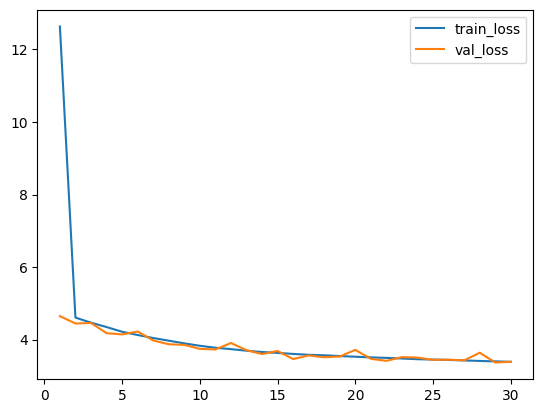

In [38]:
result_one_df = pd.DataFrame(result_one.history)

plt.plot(range(1,31),result_one_df['loss'],label="train_loss")
plt.plot(range(1,31),result_one_df['val_loss'],label="val_loss")
plt.legend()
plt.show()

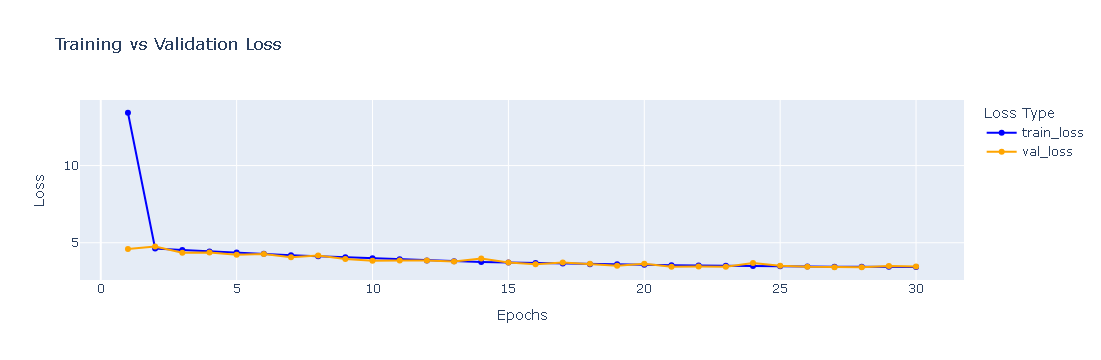

In [57]:
fig = go.Figure()

# Add the training loss line
fig.add_trace(go.Scatter(
    x=list(range(1, 51)),
    y=result_one_df['loss'],
    mode='lines+markers',  # Adds both lines and markers
    name='train_loss',
    line=dict(color='blue')
))

# Add the validation loss line
fig.add_trace(go.Scatter(
    x=list(range(1, 51)),
    y=result_one_df['val_loss'],
    mode='lines+markers',  # Adds both lines and markers
    name='val_loss',
    line=dict(color='orange')
))

# Update layout (titles and axes labels)
fig.update_layout(
    title="Training vs Validation Loss",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    legend_title="Loss Type",
    hovermode="x"  # Hover over both train and val loss at the same x point
)
fig.show()

# ARCHITECTURE 2 

In [19]:
# Changing the number of hidden layers and alpha
model_two = Sequential()
model_two.add(Dense(128, input_dim=X_train.shape[1], activation=LeakyReLU(negative_slope=0.001)))
model_two.add(Dense(128, activation=LeakyReLU(negative_slope=0.001)))
model_two.add(Dropout(0.2))
model_two.add(Dense(64, activation=LeakyReLU(negative_slope=0.001)))
model_two.add(Dense(32, activation=LeakyReLU(negative_slope=0.001)))
model_two.add(Dropout(0.2))
model_two.add(Dense(16, activation=LeakyReLU(negative_slope=0.001)))
model_two.add(Dense(1))

In [20]:
model_two.compile(
    optimizer="adam",
    loss="mse",  
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),  
        tf.keras.metrics.MeanSquaredError(),  
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.R2Score()
    ]
)

In [21]:
result_two = model_two.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - loss: 55506892.0000 - mean_absolute_error: 3862.9360 - mean_squared_error: 55506892.0000 - r2_score: 0.7509 - root_mean_squared_error: 6888.5190 - val_loss: 9813935.0000 - val_mean_absolute_error: 1537.6409 - val_mean_squared_error: 9813935.0000 - val_r2_score: 0.9560 - val_root_mean_squared_error: 3132.7200
Epoch 2/50
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 15648436.0000 - mean_absolute_error: 2196.3994 - mean_squared_error: 15648436.0000 - r2_score: 0.9294 - root_mean_squared_error: 3955.3914 - val_loss: 9351623.0000 - val_mean_absolute_error: 1477.2689 - val_mean_squared_error: 9351623.0000 - val_r2_score: 0.9580 - val_root_mean_squared_error: 3058.0422
Epoch 3/50
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 13117870.0000 - mean_absolute_error: 1977.8646 - mean_squared_error: 13117870.0000 - r2_score: 0.9410 - root_mean_squared_error: 3621.2397 - val_loss: 17529244.0000 - val_mean_absolute_error: 2567.3816 -

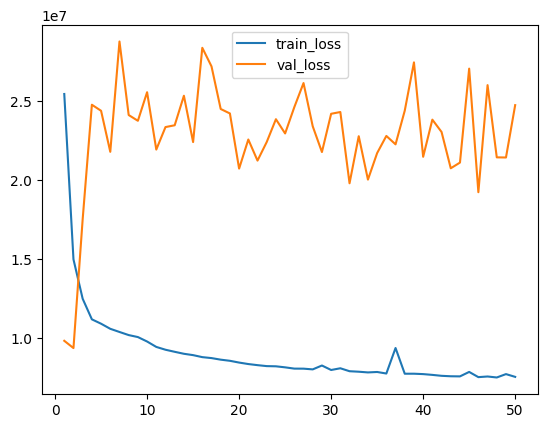

In [22]:
result_two_df = pd.DataFrame(result_two.history)

plt.plot(range(1,51),result_two_df['loss'],label="train_loss")
plt.plot(range(1,51),result_two_df['val_loss'],label="val_loss")
plt.legend()
plt.show()

# ARCHITECTURE 3

In [24]:
model_three = Sequential()
model_three.add(Dense(128, input_dim=X_train.shape[1], activation=LeakyReLU(alpha=0.001)))
model_three.add(Dense(64, activation=LeakyReLU(alpha=0.001)))
model_three.add(Dense(32, activation=LeakyReLU(alpha=0.001)))
model_three.add(Dropout(0.1))
model_three.add(Dense(16, activation=LeakyReLU(alpha=0.001)))
model_three.add(Dense(1))

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model_three.compile(
    optimizer="adam",
    loss="mse",  
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),  
        tf.keras.metrics.MeanSquaredError(),  
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.R2Score()
    ]
)

In [26]:
result_three = model_three.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 30.1153 - mean_absolute_error: 2.8512 - mean_squared_error: 30.1153 - r2_score: 0.7466 - root_mean_squared_error: 4.7638 - val_loss: 12.8247 - val_mean_absolute_error: 3.0214 - val_mean_squared_error: 12.8247 - val_r2_score: 0.8920 - val_root_mean_squared_error: 3.5812
Epoch 2/100
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 4.7008 - mean_absolute_error: 1.3096 - mean_squared_error: 4.7008 - r2_score: 0.9607 - root_mean_squared_error: 2.1675 - val_loss: 12.7071 - val_mean_absolute_error: 3.0310 - val_mean_squared_error: 12.7071 - val_r2_score: 0.8930 - val_root_mean_squared_error: 3.5647
Epoch 3/100
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 4.2295 - mean_absolute_error: 1.2436 - mean_squared_error: 4.2295 - r2_score: 0.9648 - root_mean_squared_error: 2.0563 - val_loss: 11.6669 - val_mean_absolute_error: 2.8405 - val_mean_squared_error: 11.6669 - val_r2_score: 0.9018 - val_root_mean_squared_error: 3.4157
Ep

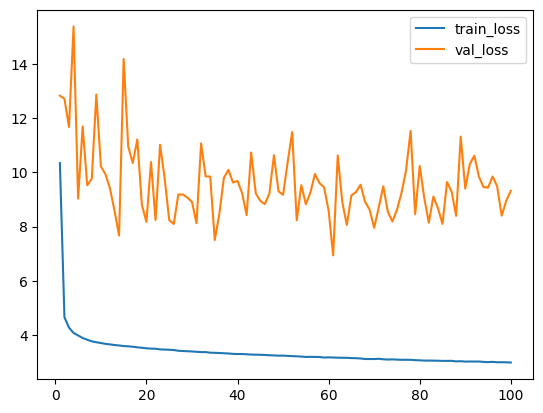

In [27]:
result_three_df = pd.DataFrame(result_three.history)

plt.plot(range(1,101),result_three_df['loss'],label="train_loss")
plt.plot(range(1,101),result_three_df['val_loss'],label="val_loss")
plt.legend()
plt.show()

# ARCHITECTURE 4

In [40]:
# Changing the number of hidden layers and alpha
model_four = Sequential()
model_four.add(Dense(256, input_dim=X_train.shape[1], activation=LeakyReLU(negative_slope=0.01)))
model_four.add(Dense(128, activation=LeakyReLU(negative_slope=0.01)))
# model_four.add(Dropout(0.1))
model_four.add(Dense(64, activation=LeakyReLU(negative_slope=0.01)))
# model_four.add(Dropout(0.1))
model_four.add(Dense(32, activation=LeakyReLU(negative_slope=0.01)))
# model_four.add(Dropout(0.1))
model_four.add(Dense(16, activation=LeakyReLU(negative_slope=0.01)))
# model_four.add(Dropout(0.1))
model_four.add(Dense(8, activation=LeakyReLU(negative_slope=0.01)))
model_four.add(Dense(1))

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [42]:
model_four.compile(
    optimizer="adam",
    loss="mean_squared_error",  
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),  
        tf.keras.metrics.MeanSquaredError(),  
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.R2Score()
    ]
)

In [43]:
result_four = model_four.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

Epoch 1/30
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - loss: 21.6846 - mean_absolute_error: 2.0640 - mean_squared_error: 21.6846 - r2_score: 0.8173 - root_mean_squared_error: 3.9603 - val_loss: 4.2213 - val_mean_absolute_error: 1.1869 - val_mean_squared_error: 4.2213 - val_r2_score: 0.9645 - val_root_mean_squared_error: 2.0546
Epoch 2/30
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 4.4022 - mean_absolute_error: 1.2710 - mean_squared_error: 4.4022 - r2_score: 0.9632 - root_mean_squared_error: 2.0977 - val_loss: 5.0239 - val_mean_absolute_error: 1.5117 - val_mean_squared_error: 5.0239 - val_r2_score: 0.9577 - val_root_mean_squared_error: 2.2414
Epoch 3/30
8406/8406 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 4.0463 - mean_absolute_error: 1.2269 - mean_squared_error: 4.0463 - r2_score: 0.9661 - root_mean_squared_error: 2.0113 - val_loss: 3.8508 - val_mean_absolute_error: 1.1252 - val_mean_squared_error: 3.8508 - val_r2_score: 0.9676 - val_root_mean_squared_error: 1.9624
Epoch 4/30


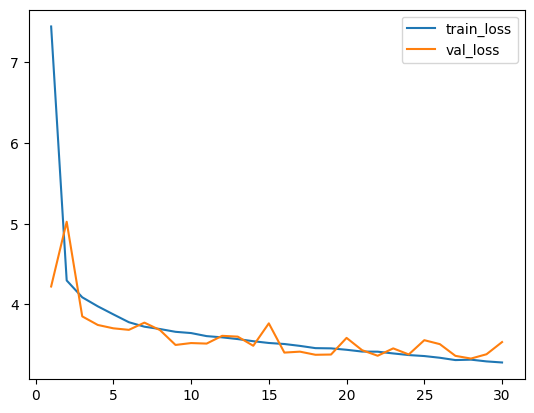

In [45]:
result_four_df = pd.DataFrame(result_four.history)
plt.plot(range(1,31),result_four_df['loss'],label="train_loss")
plt.plot(range(1,31),result_four_df['val_loss'],label="val_loss")
plt.legend()
plt.show()

In [23]:
# Prediction
y_pred = model_one.predict(X_test)
# Evaluation
MAE = mean_absolute_error(y_test, y_pred) 
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,y_pred)

print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"R2: {R2}")

2627/2627 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MAE: 1.0760097874285846
MSE: 3.4930090301596546
RMSE: 1.8689593441698122
R2: 0.9706678157489816


In [22]:
model_one.save("model.h5")

In [24]:
# Pickle the scaler
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

In [58]:
df4.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'CPI', 'Unemployment', 'Markdown', 'Year', 'Month',
       'Day', 'Weekly_Sales_Lag1', 'Weekly_Sales_Lag2',
       'Markdown_Holiday_Only', 'Markdown_NonHoliday_Only'],
      dtype='object')

In [43]:
df4["Weekly_Sales_Lag1"].max()

55.88868498227317

In [6]:
# Load the saved model
model_loaded = load_model("model.h5", custom_objects={'LeakyReLU': LeakyReLU})

In [7]:
with open("scaler.pkl", "rb") as file:
    scaler = pickle.load(file)

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Weekly_Sales transformed with lambda 0.21190295673149415: skewness = -0.075761882070792
# Unemployment transformed with lambda -0.06995164335275873: skewness = -0.007087351320171858
# Markdown transformed with lambda -0.19278533614859414

In [8]:
# Define the input data for prediction 
input_data = np.array([[1,1,0,1,151315,39.93,211.289143,1.9466531476324274,0.0,2010,2,19,41.20003876152084,35.60091488312143,0.0,0.0]]) 

# Scale the input data
input_scaled = scaler.transform(input_data)

predicted_sales = model_loaded.predict(input_scaled)

# Reverse Box-Cox transformation using the saved lambda value for 'Weekly_Sales'
fitted_lambda = 0.212
predicted_sales_original = inv_boxcox(predicted_sales, fitted_lambda)

print(f"Predicted Weekly Sales (original scale): {predicted_sales_original[0][0]-1}")

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
Predicted Weekly Sales (original scale): 38483.48828125


In [5]:
stats.boxcox(8.106,lmbda=-0.06995164335275873)

np.float64(1.9466531476324274)

In [21]:
df4.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,CPI,Unemployment,Markdown,Year,Month,Day,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Markdown_Holiday_Only,Markdown_NonHoliday_Only
2,1,1,40.223116,False,A,151315,39.93,211.289143,1.946653,0.0,2010,2,19,41.200250,35.601258,0.0,0.0
3,1,1,33.517733,False,A,151315,46.63,211.319643,1.946653,0.0,2010,2,26,40.223116,41.200250,0.0,0.0
4,1,1,34.483620,False,A,151315,46.50,211.350143,1.946653,0.0,2010,3,5,33.517733,40.223116,0.0,0.0
5,1,1,34.180747,False,A,151315,57.79,211.380643,1.946653,0.0,2010,3,12,34.483620,33.517733,0.0,0.0
6,1,1,34.600465,False,A,151315,54.58,211.215635,1.946653,0.0,2010,3,19,34.180747,34.483620,0.0,0.0


In [32]:
df4[(df4["Year"]==2010) & (df4["Month"]==2) & (df4["Day"]==19) & (df4["Store"] == 1) & (df4["Dept"]==1)]

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,CPI,Unemployment,Markdown,Year,Month,Day,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Markdown_Holiday_Only,Markdown_NonHoliday_Only
2,1,1,40.223116,False,A,151315,39.93,211.289143,1.946653,0.0,2010,2,19,41.20025,35.601258,0.0,0.0


In [33]:
df[(df["Year"]==2010) & (df["Month"]==2) & (df["Day"]==19) & (df["Store"] == 1) & (df["Dept"]==1)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,CPI,Unemployment,Markdown,Year,Month,Day
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,211.289143,8.106,0.0,2010,2,19


# MARKDOWN IMPACT ANALYSIS USING STATISTICAL TECHNIQUES.

In [34]:
holiday_sales_with_md = df4[(df4['IsHoliday'] == 1) & (df4['Markdown_Holiday_Only'] > 0)]['Weekly_Sales'].mean()
holiday_sales_without_md = df4[(df4['IsHoliday'] == 1) & (df4['Markdown_Holiday_Only'] == 0)]['Weekly_Sales'].mean()

non_holiday_sales_with_md = df4[(df4['IsHoliday'] == 0) & (df4['Markdown_NonHoliday_Only'] > 0)]['Weekly_Sales'].mean()
non_holiday_sales_without_md = df4[(df4['IsHoliday'] == 0) & (df4['Markdown_NonHoliday_Only'] == 0)]['Weekly_Sales'].mean()

print(f"""holiday_sales_with_md: {holiday_sales_with_md}
holiday_sales_without_md: {holiday_sales_without_md}
non_holiday_sales_with_md: {non_holiday_sales_with_md}
non_holiday_sales_without_md: {non_holiday_sales_without_md}""")

holiday_sales_with_md: 26.715876337887455
holiday_sales_without_md: 26.553520616757275
non_holiday_sales_with_md: 26.313157342965994
non_holiday_sales_without_md: 26.36322218184656


In [37]:
# T-test for holiday markdown vs non-markdown weeks
t_stat, p_val = stats.ttest_ind(df4[(df4['IsHoliday'] == 1) & (df4['Markdown'] > 0)]['Weekly_Sales'],
                                df4[(df4['IsHoliday'] == 1) & (df4['Markdown'] == 0)]['Weekly_Sales'])
print(f"T-statistic: {t_stat}, p-value: {p_val}")

# SInce p value is not less than 0.05 we could not say that Markdown is having significant impact in sales.


T-statistic: 1.2404812283556192, p-value: 0.21480729877738491
